In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


In [261]:
from scipy.stats import rv_continuous
import numpy as np
from numpy import exp, sqrt
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import wkbl
from wkbl.particle import capture as ca
import fdulib as vdf
import sys
import glob
from scipy.misc import derivative as da
from matplotlib import rc
import datetime
from scipy.interpolate import interp1d
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
dens_haloB = 0.44
from astropy.cosmology import FlatLambdaCDM, LambdaCDM,z_at_value, Planck15
import astropy.units as u
cosmo =LambdaCDM(H0=69, Om0=0.286, Ode0=0.7)

In [105]:
Gau_color = "#531c73"
GenMax_color = "#3c731c"
Tsalis_color = "#bf6139"
Edd_color = "#2f5891"
shm_color = "k"
data_color = "#a63d55"

Solar velocity arround GC     v_Sun =  220.0  km / s
Wimp density                    rho =  0.3  GeV / km^3 
Wimp-nucleon cross section    sigma =  5.62403697997e-06 km^2 SD Wimp-proton    
ffrom Ellis,Olive and Savage (2008) 
 proton mass                    m_p =  0.938272  GeV for SD is Hydorgen mass
Nuclear radius(depends on m_i)  r_i =  1.2e-13  ^km for hydrogen
Escape velocity               u_esc =  294.0 km / s
Dispertion velocity             v_0 =  27010000.0 km /s


<IPython.core.display.Javascript object>


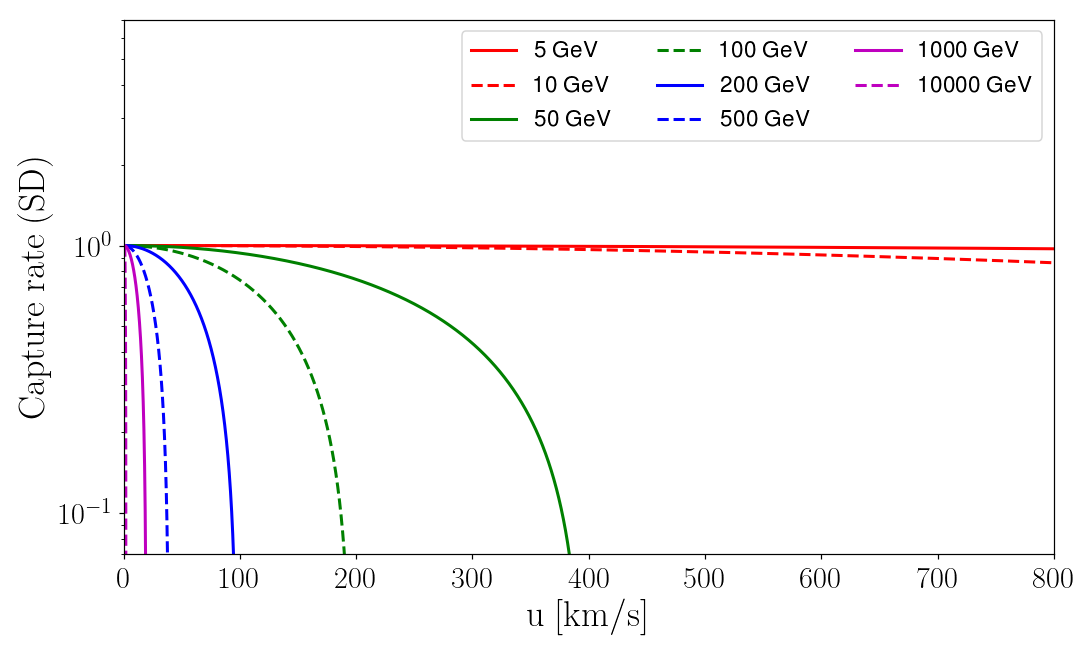

0 5
1 10
2 50
3 100
4 200
5 500
6 1000
7 10000


In [3]:
ca.get_variables() # prints variables in use (check captureLib)
### Plot parameters ###
fig ,ax = plt.subplots(figsize=[10,6])
ax.set_yscale('log')
ax.set_ylim([0.07,7])
ax.set_xlim([0,800])
ax.set_xlabel(r'$\rm u \;[km/s]$',fontsize=24)
ax.set_ylabel(r'$\rm Capture\; rate\; (SD)$',fontsize=24)
colors = ('r-','r--', 'g-','g--', 'b-','b--', 'm-','m--', )
########################
normal=ca.normalize_max
arrays=8 * [[]]
x_array = [i for i in np.arange(1,800.,0.1)]
particle_physics = np.vectorize(ca.caprate_GOU)
masses = (5, 10, 50, 100, 200, 500, 1000, 10000)
i=-1
for m,c in zip(masses,colors):
            i +=1
            print i, m
            arrays[i]=particle_physics(x_array,m)
            title = str(m)+' GeV'
            ax.plot(x_array, normal(arrays[i]),c, label=title,linewidth=2.0)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
legend = ax.legend(loc='upper right', ncol=3, shadow=False, fontsize=15)
frame = legend.get_frame()

fig.tight_layout()

In [4]:
v_Sun  = 220.
v_esc  = 544.
rho_dm = 0.4 
x = [i for i in np.arange(0.1,v_Sun+v_esc)]
def product(m,f):
    """
    the producto to be inside the integral
    """
    x = [i for i in np.arange(0.1,v_Sun+v_esc)]
    def inside_int(u):
        va = vdf.gal_to_sun(u,f)
        va2 = ca.caprate_GOU(u, m)# rms=str(f)[10])
        if va2 < 0:
                va2 = 1e-15
        return va * va2
    array = map(inside_int,x)
    final = np.trapz(array)
    return final

In [616]:
v_Sun+v_esc

764.0

In [5]:
GOUlD_int = np.vectorize(product)

In [6]:
x_array = np.logspace(0.1, 4, num=100)
first = GOUlD_int(x_array,vdf.shm_gal)

In [413]:
x = [i for i in np.arange(0.1,v_Sun+v_esc)]
x2 = [i for i in np.arange(0.1,v_Sun+v_esc,20)]


def capture_cut(m):
    uss = np.linspace(0,1000,100)
    nonorm=particle_physics(uss,m)
    yesnor=np.array(ca.normalize_max(nonorm))
    return uss[np.abs(yesnor-0.09)==(np.abs(yesnor-0.09)).min()]


def norm(f,cut):
    def inside_int(u):
        va = f(u)#vdf.gal_to_sun(u,f)
        return va
    step=1.
    x_loc = [i for i in np.arange(0.1,cut,step)]
    array = map(inside_int,x_loc)
    norm = np.trapz(array)*step
    return norm

def norms(f,cut):
    def inside_int(u):
        va = vdf.gal_to_sun(u,f)*u
        return va
    step=1.
    x_loc = [i for i in np.arange(0.1,cut,step)]
    array = map(inside_int,x_loc)
    norm = np.trapz(array)*step
    return norm

def mu(f,cut):
    """
    the producto to be inside the integral
    """
    step=0.2
    x_loc = [i for i in np.arange(0.1,cut,step)]
    def inte(u):
        va = vdf.gal_to_sun(u,f)
        return va *u**2
    array = map(inte,x_loc)
    final = np.trapz(array)
    return final*step/norms(f,cut)

def var(f,cut):
    """
    the producto to be inside the integral
    """
    def meanofsquare(u):
        va = vdf.gal_to_sun(u,f) *u
        return va * (u**2) 
    step=0.2
    x_loc = [i for i in np.arange(0.1,cut,step)]
    mx = mu(f,cut)
    mx2 = map(meanofsquare,x_loc)
    Emx2 = np.trapz(mx2)*step/norms(f,cut)
    final = Emx2 - mx**2
    return final

cut= 900.

print "shm", mu(vdf.shm_gal,cut),np.sqrt(var(vdf.shm_gal,cut))
print "lin", mu(vdf.lin_gal,cut),np.sqrt(var(vdf.lin_gal,cut))
print "mao",mu(vdf.mao_gal,cut),np.sqrt(var(vdf.mao_gal,cut))



shm 322.1515322218489 125.08637947202078
lin 334.5978768266109 126.28496659776033
mao 283.52751017473526 106.2901767255741


In [8]:
def thismu(m,f,n):
    step=0.2
    x_loc = [i for i in np.arange(0.1,1000,step)]
    def inte(u):
        va = vdf.gal_to_sun(u,f)
        va2 = particle_physics(u,m)
        return va * va2
    array = map(inte,x_loc)
    final = np.trapz(array)
    return final*step/n

def variance_OG(m,f,cut,mymu,n):
    step=0.2
    x_loc = [i for i in np.arange(0.1,cut,step)]
    def inte(u):
        va = vdf.gal_to_sun(u,f)
        va2 = particle_physics(u,m)
        return va * u * ( (va2/u) - mymu )**2
    array = map(inte,x_loc)
    final = np.trapz(array)
    return final*step/n

In [54]:
def sigma(mass,fdv,n,cut=1e3):
    local_mu = thismu(mass,fdv,n)
    return np.sqrt(variance_OG(mass,fdv,cut,local_mu,n))

get_sigma = np.vectorize(sigma)

def product(m,f):
    """
    the producto to be inside the integral
    """
    def inside_int(u):
        va = vdf.gal_to_sun(u,f)
        va2 = ca.caprate_GOU(u, m)#, rms=str(f)[10])
        if va2 < 0:
                va2 = 0.0
        return va * va2
    array = map(inside_int,x)
    final = np.trapz(array)
    return final/norms(f,1000)

E_g = np.vectorize(product)

# Generalized Gaussian

In [36]:
def fun(x, mu, sig,alpha):return exp(-((x-mu)**2 / sig**2)**alpha)
mu=251.254257
sig=155.876263
alpha=1.32608662
uno = np.linspace(1,1000,1000)
dos = fun(uno, mu, sig,alpha)
N_gaus = np.trapz(dos, uno)
vesc=1000
def gaussian(x,transform=False,esc=vesc, n=N_gaus ):
    mu=251.254257
    sig=155.876263
    alpha=1.32608662
    if x>esc:
        return 1e-30
    else:
        t = exp(-((x-mu)**2 / sig**2)**alpha)
        if not (transform):
            return t / n
        if (transform):
            return t / x**2 / n


In [28]:
%%time
fdu_here = gaussian
n = norms(fdu_here,1e3)
mass_array = np.logspace(0.1, 4, num=50)
sigma_gaussian = get_sigma(mass_array, fdu_here,n)
gau_cap = E_g(mass_array, fdu_here)

CPU times: user 2min 6s, sys: 549 ms, total: 2min 7s
Wall time: 2min 6s


# Generalized Maxwellian

In [37]:
def fun(x, sig,alpha):return x**2 * exp(-(x**2 / sig**2)**alpha)
sig = 264.538767
alpha = 1.23185213
uno = np.linspace(1,1000,1000)
dos = fun(uno, sig,alpha)
N_max = np.trapz(dos, uno)
vesc=1000
def gen_max(x,transform=False,esc=vesc, n=N_max ):
    sig = 264.538767
    alpha = 1.23185213
    if x>esc:
        return 1e-30
    else:
        t = x**2 * exp(-(x**2 / sig**2)**alpha)
        if not (transform):
            return t / n
        if (transform):
            return t / x**2 / n


In [38]:
%%time
fdu_here = gen_max
n = norms(fdu_here,1e3)
sigma_gen_max = get_sigma(mass_array, fdu_here,n)
genM_cap = E_g(mass_array, fdu_here)

CPU times: user 1min 42s, sys: 620 ms, total: 1min 43s
Wall time: 1min 42s


# Tsallis

In [47]:
def fun(x,sig,q):return np.nan_to_num(x**2 *((1-(1-q)*(x**2 / sig**2))**(q/(1-q))))
sig = 245.882269 
q = 0.86378724 
uno = np.linspace(1,1000,1000)
dos = fun(uno, sig,q)
N_tsa = np.trapz(dos, uno)
print N_tsa
vesc=1000
def tsallis(x,transform=False,esc=vesc, n=N_tsa ):
    sig = 245.882269 
    q = 0.86378724
    if x>esc:
        return 1e-30
    else:
        t = np.nan_to_num(x**2 *((1-(1-q)*(x**2 / sig**2))**(q/(1-q))))
        if not (transform):
            return t / n
        if (transform):
            return t / x**2 / n

6272936.751351095


In [55]:
%%time
fdu_here = tsallis
n = norms(fdu_here,1e3)
print "sigma"
sigma_tsallis = get_sigma(mass_array, fdu_here,n)
print "capture"
tsa_cap = E_g(mass_array, fdu_here)


sigma
capture
CPU times: user 3min 57s, sys: 1.52 s, total: 3min 59s
Wall time: 3min 57s


# Standard Halo Model

In [57]:
%%time
fdu_here = vdf.shm_gal
n = norms(fdu_here,1e3)
print "sigma"
sigma_shm = get_sigma(mass_array, fdu_here,n)
print "capture"
shm_cap = E_g(mass_array, fdu_here)

sigma
capture
CPU times: user 1min 42s, sys: 569 ms, total: 1min 43s
Wall time: 1min 42s


# Eddington on McMillan

In [585]:
edd_file = np.loadtxt("../../datafiles/rho_vs_t_FILES/McMillan/fv_Eddington_McMillan_NFW_DM_baryons_8.0kpc.txt")
f_edd = interp1d(edd_file[:,0],edd_file[:,1])

In [586]:
def edd_McM(x,transform=False,esc=vesc, n=N_tsa ):
    if x>esc:
        return 1e-30
    else:
        try:
            t = f_edd(x)
        except:
            t=0
        if not (transform):
            return t
        if (transform):
            return t / x**2 

In [587]:
%%time
fdu_here = edd_McM
n = norms(fdu_here,1e3)
print "sigma"
sigma_edd = get_sigma(mass_array, fdu_here,n)
print "capture"
edd_cap = E_g(mass_array, fdu_here)

sigma
capture
CPU times: user 5min 16s, sys: 700 ms, total: 5min 16s
Wall time: 5min 17s


# Eddington HALOB

In [561]:
edd_file = np.loadtxt("/home/arturo/Documents/LAM/LAM2LUPM/HALOB/fdvs/fv_Eddington_halo_B_DM_baryons_Rmax=881.61kpc_8kpc_no_divergence.txt")
f_edd_HALOB = interp1d(edd_file[:,0],edd_file[:,1])

In [562]:
def edd_HB(x,transform=False,esc=vesc, n=N_tsa ):
    if x>esc:
        return 1e-30
    else:
        try:
            t = f_edd_HALOB(x)
        except:
            t=0
        if not (transform):
            return t
        if (transform):
            return t / x**2 

In [563]:
%%time
fdu_here = edd_HB
n = norms(fdu_here,1e3)
print "sigma"
sigma_edd_HB = get_sigma(mass_array, fdu_here,n)
print "capture"
edd_HB_cap = E_g(mass_array, fdu_here)

sigma
capture
CPU times: user 5min 49s, sys: 614 ms, total: 5min 50s
Wall time: 5min 51s


# Maxwellian simulation

In [513]:


def maxw(v,sigma,vesc):
    N = np.sqrt(32 * np.pi) * v**2 / sigma**3
    return N * (np.exp(- v**2 / 2. / sigma**2 )- np.exp(-vesc**2/2./sigma**2))


get_maxw = np.vectorize(maxw)
N_max = np.trapz(get_maxw(v_array,165.2256,497.32),v_array)

def maxwellianHB(x,transform=False,esc=vesc, n=N_max ):
    sigma8=165.2256
    vesc = 497.32
    N = np.sqrt(32 * np.pi) * x**2 / sigma8**3
    if x>esc:
        return 1e-30
    else:
        t = N * (np.exp(- x**2 / 2. / sigma8**2 )- np.exp(-vesc**2/2./sigma8**2))
        if not (transform):
            return t / n
        if (transform):
            return t / x**2 / n

In [518]:
%%time
fdu_here = maxwellianHB
N_max = norms(fdu_here,1e3)
print "sigma"
sigma_edd_HB = get_sigma(mass_array, fdu_here,n)
print "capture"
max_HB_cap = E_g(mass_array, fdu_here)

sigma
capture
CPU times: user 2min 45s, sys: 836 ms, total: 2min 46s
Wall time: 2min 46s


# Data

In [307]:
vdf_from_file = np.loadtxt("../../datafiles/rho_vs_t_FILES/HALOB1kpc/fdv_HALOB417_50bins.txt")



In [ ]:
histo = vdf_from_file[:,1]
bino = vdf_from_file[:,0]
def mydata(v):
    diff = np.abs(bino-v)
    
    
    

In [414]:
def discret_f(x,transform=False,esc=vesc, n=N_max ):
    sig = 264.538767
    alpha = 1.23185213
    diff = np.abs(bin_aux-x)
    index = np.where(diff==diff.min())
    if x>esc:
        return 1e-30
    else:
        t = hist_aux[index]
        if not (transform):
            return t
        if (transform):
            return t / hist_aux[index]**2 


E_g_discrete = np.vectorize(product_d)

In [521]:
%%time
fdu_here = discret_f
#n = norms(fdu_here,1e3)
print "sigma"
#sigma_edd_HB = get_sigma(mass_array, fdu_here,n)
print "capture"
vdf_from_file = np.loadtxt("../../datafiles/rho_vs_t_FILES/HALOB1kpc/fdv_HALOB417_50bins.txt")
hist_aux = vdf_from_file[:,1]
bin_aux = vdf_from_file[:,0]-(vdf_from_file[1,0]-vdf_from_file[0,0])/2.
wi = bin_aux[1]-bin_aux[0]
bino = np.concatenate([[bin_aux[0]-3*wi,bin_aux[0]-2*wi,bin_aux[0]-wi],bin_aux])
bino = np.concatenate([bino,[bin_aux[-1]+wi,bin_aux[-1]+2*wi,bin_aux[-1]+3*wi]])
histo = np.concatenate([[0,0,0],hist_aux])
histo = np.concatenate([histo,[0,0,0]])
fff = interp1d(bino,histo)
def discret_f(x,transform=False,esc=vesc, n=N_max ):
    if x>esc:
        return 1e-30
    else:
        t = fff(x)
        if not (transform):
            return t
        if (transform):
            return t /x**2 

fdu_here = discret_f

E_g_discrete = np.vectorize(product_d)

data_HB_cap = E_g(mass_array, fdu_here)

sigma
capture
CPU times: user 2min 24s, sys: 34.4 ms, total: 2min 24s
Wall time: 2min 24s


In [461]:
wi = bin_aux[1]-bin_aux[0]
bino = np.concatenate([[bin_aux[0]-3*wi,bin_aux[0]-2*wi,bin_aux[0]-wi],bin_aux])
bino = np.concatenate([bino,[bin_aux[-1]+wi,bin_aux[-1]+2*wi,bin_aux[-1]+3*wi]])
histo = np.concatenate([[0,0,0],hist_aux])
histo = np.concatenate([histo,[0,0,0]])
fff = interp1d(bino,histo)

## HALO B

In [371]:
vdf_from_file = np.loadtxt("../../datafiles/rho_vs_t_FILES/Mochima1kpc/fdv_Mo_SF028.txt")
hist_aux = vdf_from_file[:,1]
bin_aux = vdf_from_file[:,0]-(vdf_from_file[1,0]-vdf_from_file[0,0])/2.
haloBdataoriginal = get_discrete(mass_array)
vdf_from_file = np.loadtxt("../../datafiles/rho_vs_t_FILES/HALOB1kpc/fdv_HALOB417.txt")
hist_aux = vdf_from_file[:,1]
bin_aux = vdf_from_file[:,0]-(vdf_from_file[1,0]-vdf_from_file[0,0])/2.
haloBdataz0 = get_discrete(mass_array)


In [372]:
colors = np.array(["#7fb3d5","#5499c7","#2980b9","#2471a3","#1f618d","#1f618d","#154360",
                   "#4a235a","#5b2c6f","#6c3483","#7d3c98","#8e44ad","#a569bd","#bb8fce"
                  ])

<IPython.core.display.Javascript object>


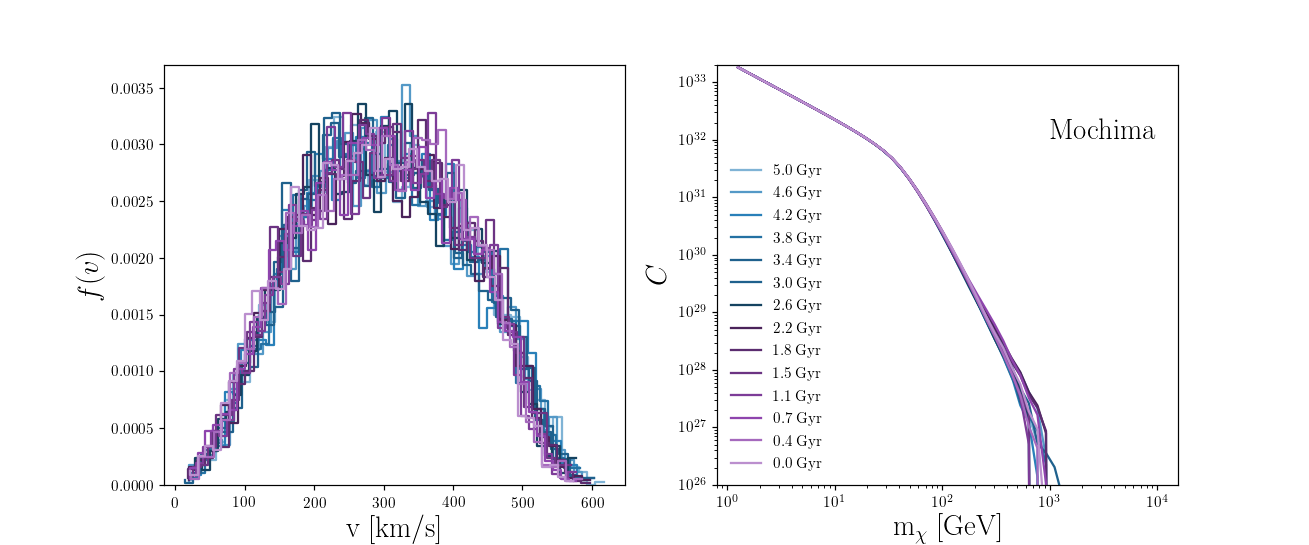

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


In [606]:
fig, [ax,ax1] = plt.subplots(1,2,figsize=[12,5])


ax1.set_xscale("log")
ax2.set_xscale("log")

ax1.set_yscale("log")
ax1.set_ylim([1e26,2e33])
ax.set_ylim([0,0.0037])


fonto=19
ax.set_xlabel(r"$\rm v\;[km/s]$",fontsize=fonto )
ax.set_ylabel(r"$f(v)$",fontsize=fonto )
ax1.set_xlabel(r"$\rm m_{\chi}\;[GeV]$",fontsize=fonto )
ax1.set_ylabel(r"$C$",fontsize=fonto )

files = glob.glob("../../datafiles/rho_vs_t_FILES/Mochima1kpc/fdv*")
z = np.array(np.loadtxt("../../datafiles/rho_vs_t_FILES/Mochima1kpc/dens_file.txt")[:,-1])
index = np.array([])
for i in range(len(files)):
    index= np.append(index,int(files[i][-6:-4])-28)
    
order = np.argsort(index)
print index[np.argsort(index)]
j=0
for i in order:
    time = cosmo.age(0).value-cosmo.age(z[j]).value
    fdv = np.loadtxt(files[i])
    width = (fdv[1,0]-fdv[0,0])
    #if j<1 or j>12 or j==6:
    if j>=0:# or j>12 or j==6:

        ax.step(fdv[:,0],fdv[:,1],c=colors[j],label=r"$\rm {0:.1f} \;Gyr$".format(time))
        hist_aux = fdv[:,1]
        bin_aux = fdv[:,0]-width
        haloBdata = get_discrete(mass_array)
        ax1.plot(mass_array, haloBdata,c=colors[j],label=r"$\rm {0:.1f} \;Gyr$".format(time))

    j+=1
ax1.text(1e3,1e32,r"$\rm Mochima$", fontsize=fonto)
leg = ax1.legend(loc='lower left', ncol=1, shadow=False, fontsize=10)
leg.get_frame().set_linewidth(0.0)


<IPython.core.display.Javascript object>


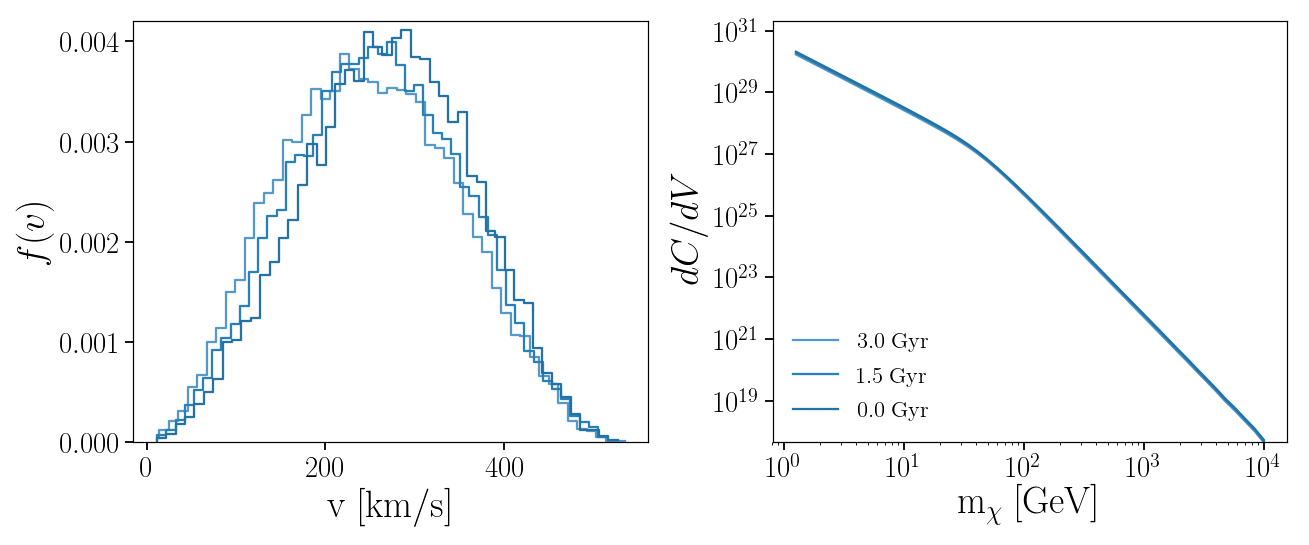

323
389
417
355
[ 0. 32. 66. 94.]
here is one
this---> 800.0
here is one
this---> 800.0
here is one
this---> 800.0


In [624]:
fig, [ax,ax1] = plt.subplots(1,2,figsize=[12,5])


ax1.set_xscale("log")
ax2.set_xscale("log")

ax1.set_yscale("log")
ax1.set_ylim([4.5e17,2e31])
ax.set_ylim([0,0.0042])


fonto=25
ax.set_xlabel(r"$\rm v\;[km/s]$",fontsize=fonto )
ax.set_ylabel(r"$f(v)$",fontsize=fonto )
ax1.set_xlabel(r"$\rm m_{\chi}\;[GeV]$",fontsize=fonto )
ax1.set_ylabel(r"$dC/dV$",fontsize=fonto )

files = glob.glob("../../datafiles/rho_vs_t_FILES/HALOB1kpc/fdv*")
z = np.array(np.loadtxt("../../datafiles/rho_vs_t_FILES/HALOB1kpc/dens_file.txt")[:,-1])
densities = np.array([0.24664077, 0.29900605, 0.33903171, 0.38279047])
index = np.array([])
for i in range(len(files)):
    try: 
        ind = int(files[i][-7:-4])
    except:
        continue
    if ind < 323:
        continue
    print ind
    index= np.append(index,ind-323)

order = np.argsort(index)
print index[np.argsort(index)]
j=0
for i in order:
    time = cosmo.age(0).value-cosmo.age(z[j]).value
    fdv = np.loadtxt(files[i])
    
    width = (fdv[1,0]-fdv[0,0])
    if j>0:
        print "here is one"
        ax.step(fdv[:,0],fdv[:,1],c=colors[j],label=r"$\rm {0:.1f} \;Gyr$".format(time))
        hist_aux = fdv[:,1]
        bin_aux = fdv[:,0]-(fdv[1,0]-fdv[0,0])/2.
        wi = bin_aux[1]-bin_aux[0]
        bino = np.concatenate([[bin_aux[0]-3*wi,bin_aux[0]-2*wi,bin_aux[0]-wi],bin_aux])
        extention = np.linspace(bin_aux[-1]+wi,800,(800-bin_aux[-1]+wi)/wi)
        print "this--->",extention[-1]
        bino = np.concatenate([bino,extention])
        histo = np.concatenate([[0,0,0],hist_aux])
        histo = np.concatenate([histo,np.zeros(len(extention))])
        fff = interp1d(bino,histo)
        def discret_f(x,transform=False,esc=vesc, n=N_max ):
            if x>esc:
                return 1e-30
            else:
                t = fff(x)
                if not (transform):
                    return t
                if (transform):
                    return t /x**2 

        fdu_here = discret_f

        E_g_discrete = np.vectorize(product_d)

        data_Mo = E_g(mass_array, fdu_here)
        #hist_aux = fdv[:,1]
        #bin_aux = fdv[:,0]-width
        #haloBdata = get_discrete(mass_array)
        ax1.plot(mass_array, densities[j]*data_Mo/ mass_array,c=colors[j],label=r"$\rm {0:.1f} \;Gyr$".format(time))

    j+=1
ax1.text(1e3,1e32,r"$\rm Mochima$", fontsize=fonto)

ax.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)
leg = ax1.legend(loc='lower left', ncol=1, shadow=False, fontsize=15)
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

In [622]:
print extention
print np.linspace(bin_aux[-1]+wi,800,(800-bin_aux[-1]+wi)/wi)

[327.96570486322, 334.41044753766, 340.8551902121, 347.29993288654, 353.74467556098, 360.18941823542, 366.63416090986, 373.0789035843, 379.52364625874003, 385.96838893318]
[327.96570486 334.34454669 340.72338852 347.10223034 353.48107217
 359.85991399 366.23875582 372.61759765 378.99643947 385.3752813
 391.75412312 398.13296495 404.51180678 410.8906486  417.26949043
 423.64833226 430.02717408 436.40601591 442.78485773 449.16369956
 455.54254139 461.92138321 468.30022504 474.67906687 481.05790869
 487.43675052 493.81559234 500.19443417 506.573276   512.95211782
 519.33095965 525.70980147 532.0886433  538.46748513 544.84632695
 551.22516878 557.60401061 563.98285243 570.36169426 576.74053608
 583.11937791 589.49821974 595.87706156 602.25590339 608.63474521
 615.01358704 621.39242887 627.77127069 634.15011252 640.52895435
 646.90779617 653.286638   659.66547982 666.04432165 672.42316348
 678.8020053  685.18084713 691.55968896 697.93853078 704.31737261
 710.69621443 717.07505626 723.453898

<IPython.core.display.Javascript object>


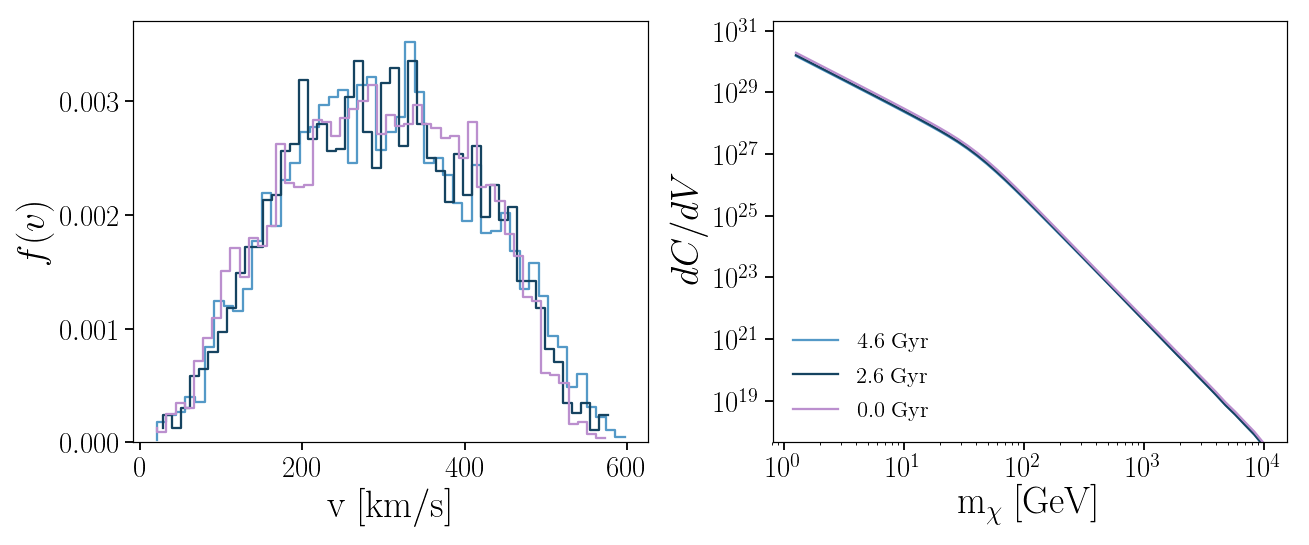

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
here is one
here is one
here is one


In [609]:
fig, [ax,ax1] = plt.subplots(1,2,figsize=[12,5])


ax1.set_xscale("log")
ax2.set_xscale("log")

ax1.set_yscale("log")
ax1.set_ylim([4.5e17,2e31])
ax.set_ylim([0,0.0037])


fonto=25
ax.set_xlabel(r"$\rm v\;[km/s]$",fontsize=fonto )
ax.set_ylabel(r"$f(v)$",fontsize=fonto )
ax1.set_xlabel(r"$\rm m_{\chi}\;[GeV]$",fontsize=fonto )
ax1.set_ylabel(r"$dC/dV$",fontsize=fonto )

files = glob.glob("../../datafiles/rho_vs_t_FILES/Mochima1kpc/fdv*")
z = np.array(np.loadtxt("../../datafiles/rho_vs_t_FILES/Mochima1kpc/dens_file.txt")[:,-1])
densities = np.array([0.29463013, 0.29672212, 0.30554599, 0.3221135 , 0.31664693,
       0.31377514, 0.31566058, 0.3206044 , 0.34720265, 0.33926309,
       0.34405225, 0.34834411, 0.37320238, 0.37720658])
index = np.array([])
for i in range(len(files)):
    index= np.append(index,int(files[i][-6:-4])-28)
    
order = np.argsort(index)
print index[np.argsort(index)]
j=0
for i in order:
    time = cosmo.age(0).value-cosmo.age(z[j]).value
    fdv = np.loadtxt(files[i])
    
    width = (fdv[1,0]-fdv[0,0])
    if j<1 or j>12 or j==6:
        print "here is one"
        ax.step(fdv[:,0],fdv[:,1],c=colors[j],label=r"$\rm {0:.1f} \;Gyr$".format(time))
        hist_aux = fdv[:,1]
        bin_aux = fdv[:,0]-(fdv[1,0]-fdv[0,0])/2.
        wi = bin_aux[1]-bin_aux[0]
        bino = np.concatenate([[bin_aux[0]-3*wi,bin_aux[0]-2*wi,bin_aux[0]-wi],bin_aux])
        bino = np.concatenate([bino,[bin_aux[-1]+wi,bin_aux[-1]+2*wi,bin_aux[-1]+3*wi]])
        histo = np.concatenate([[0,0,0],hist_aux])
        histo = np.concatenate([histo,[0,0,0]])
        fff = interp1d(bino,histo)
        def discret_f(x,transform=False,esc=vesc, n=N_max ):
            if x>esc:
                return 1e-30
            else:
                t = fff(x)
                if not (transform):
                    return t
                if (transform):
                    return t /x**2 

        fdu_here = discret_f

        E_g_discrete = np.vectorize(product_d)

        data_Mo = E_g(mass_array, fdu_here)
        #hist_aux = fdv[:,1]
        #bin_aux = fdv[:,0]-width
        #haloBdata = get_discrete(mass_array)
        ax1.plot(mass_array, densities[j]*data_Mo/ mass_array,c=colors[j],label=r"$\rm {0:.1f} \;Gyr$".format(time))

    j+=1
ax1.text(1e3,1e32,r"$\rm Mochima$", fontsize=fonto)

ax.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)
leg = ax1.legend(loc='lower left', ncol=1, shadow=False, fontsize=15)
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()


In [605]:
(0.39*data_Mo/ mass_array).min()

4.295279018264177e+17

# HALO B

<IPython.core.display.Javascript object>


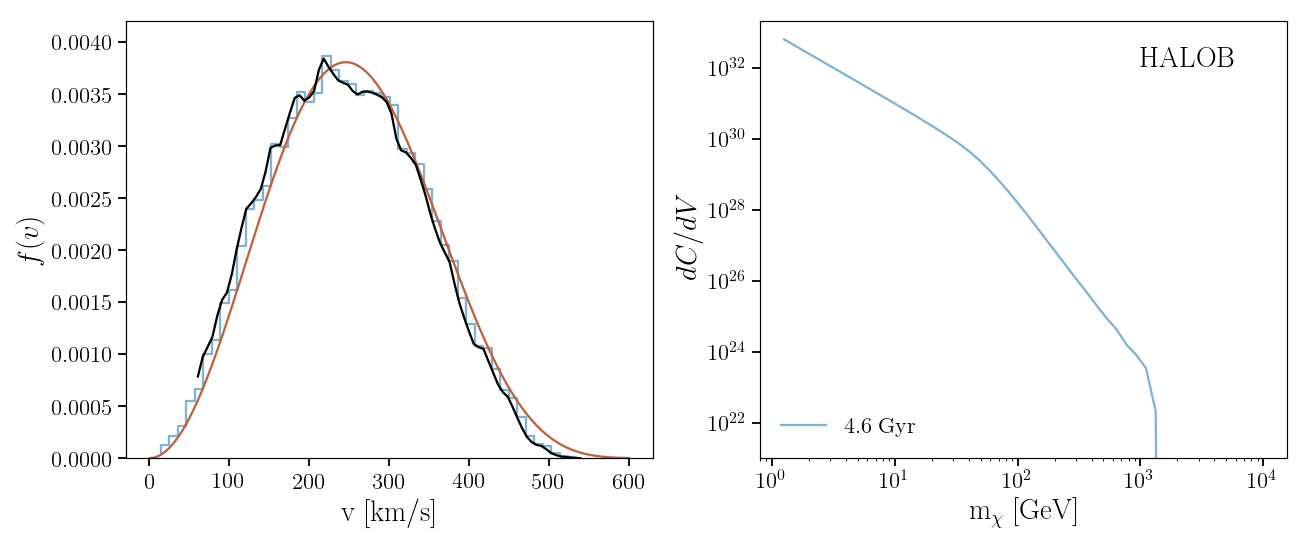

323
389
417
355
[ 0. 32. 66. 94.]


In [463]:

fig, [ax,ax1] = plt.subplots(1,2,figsize=[12,5])


ax1.set_xscale("log")
ax2.set_xscale("log")

ax1.set_yscale("log")
ax1.set_ylim([1e21,2e33])
ax.set_ylim([0,0.0042])


fonto=19
ax.set_xlabel(r"$\rm v\;[km/s]$",fontsize=fonto )
ax.set_ylabel(r"$f(v)$",fontsize=fonto )
ax1.set_xlabel(r"$\rm m_{\chi}\;[GeV]$",fontsize=fonto )
ax1.set_ylabel(r"$dC/dV$",fontsize=fonto )

files = glob.glob("../../datafiles/rho_vs_t_FILES/HALOB1kpc/fdv*")
z = np.array(np.loadtxt("../../datafiles/rho_vs_t_FILES/HALOB1kpc/dens_file.txt")[:,-1])
index = np.array([])
for i in range(len(files)):
    try: 
        ind = int(files[i][-7:-4])
    except:
        continue
    if ind < 323:
        continue
    print ind
    index= np.append(index,ind-323)

order = np.argsort(index)
print index[np.argsort(index)]
j=0
for i in order:
    time = cosmo.age(0).value-cosmo.age(z[j]).value
    fdv = np.loadtxt(files[i])
    fdv = np.loadtxt("../../datafiles/rho_vs_t_FILES/HALOB1kpc/fdv_HALOB417_50bins.txt")

    width = (fdv[1,0]-fdv[0,0])
    #if j<1 or j>12 or j==6:
    if j==0:# or j>12 or j==6:

        ax.step(fdv[:,0],fdv[:,1],c=colors[3*j],label=r"$\rm {0:.1f} \;Gyr$".format(time))
        hist_aux = fdv[:,1]
        bin_aux = fdv[:,0]-width
        haloBdata = get_discrete(mass_array)
        ax1.plot(mass_array, 0.43*haloBdata/mass_array,c=colors[3*j],label=r"$\rm {0:.1f} \;Gyr$".format(time))

    j+=1
ax.plot(v_array,tsatsa(v_array),c=Tsalis_color, label=r"$\rm Tsallis$")
ax.plot(v_array[10:-10],fff(v_array[10:-10]),c='k')

ax1.text(1e3,1e32,r"$\rm HALO B$", fontsize=fonto)
leg = ax1.legend(loc='lower left', ncol=1, shadow=False, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
leg.get_frame().set_linewidth(0.0)
fig.tight_layout()

<IPython.core.display.Javascript object>


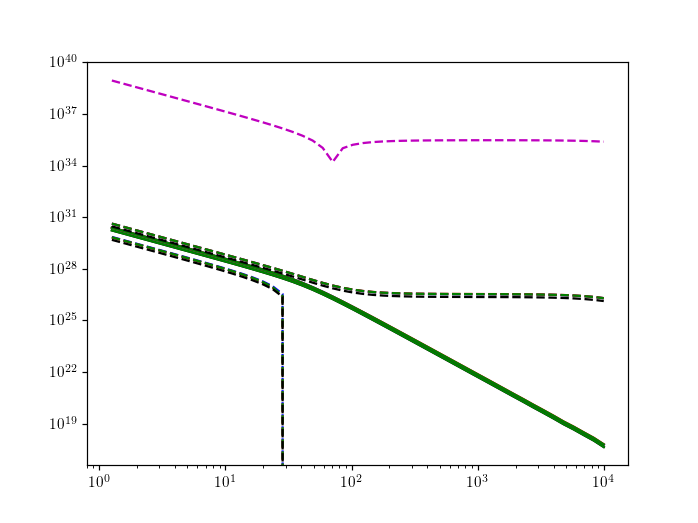

In [519]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")

ax.plot(mass_array, dens_haloB*gau_cap/mass_array,'b-')
ax.plot(mass_array, dens_haloB*(gau_cap+sigma_gaussian)/mass_array,'b--')
ax.plot(mass_array, dens_haloB*(gau_cap-sigma_gaussian)/mass_array,'b--')

ax.plot(mass_array, dens_haloB*genM_cap/mass_array,'r-')
ax.plot(mass_array, dens_haloB*(genM_cap+sigma_gen_max)/mass_array,'r--')
ax.plot(mass_array, dens_haloB*(genM_cap-sigma_gen_max)/mass_array,'r--')

ax.plot(mass_array, dens_haloB*tsa_cap/mass_array,'g-')
ax.plot(mass_array, dens_haloB*(tsa_cap+sigma_tsallis)/mass_array,'g--')
ax.plot(mass_array, dens_haloB*(tsa_cap-sigma_tsallis)/mass_array,'g--')


ax.plot(mass_array, 0.3*shm_cap/mass_array,'k-')
ax.plot(mass_array, 0.3*(shm_cap+sigma_shm)/mass_array,'k--')
ax.plot(mass_array, 0.3*(shm_cap-sigma_shm)/mass_array,'k--')




ax.plot(mass_array, 0.3* max_HB_cap/mass_array,'g-')
ax.plot(mass_array, 0.3*(edd_HB_cap + sigma_edd_HB)/mass_array,'m--')
ax.plot(mass_array, 0.3*(edd_HB_cap - sigma_edd_HB )/mass_array,'m--')

<IPython.core.display.Javascript object>


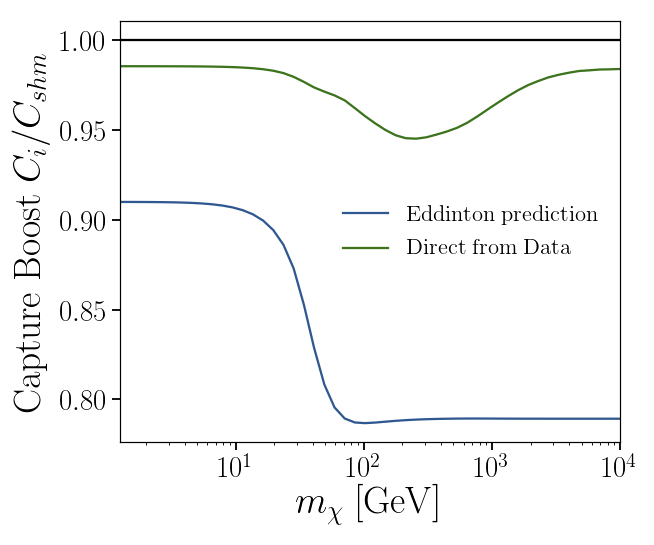

In [591]:
fig, ax = plt.subplots(figsize=[6,5])
ax.set_xscale('log')
#ax.set_ylim([0.89,1.02])
ax.set_xlim([mass_array[0],mass_array[-1]])

ax.set_xlabel(r"$m_{\chi} \; \rm [GeV]$", fontsize=25)
ax.set_ylabel(r"$\rm Capture\; Boost\;$$ C_i / C_{shm}$", fontsize=25)

#ax.plot(mass_array, tsa_cap / max_HB_cap, c=Tsalis_color, label=r"$\rm Tsallis\; fit$")
#ax.plot(mass_array, gau_cap / max_HB_cap, c=Gau_color, label=r"$\rm Gaussian\;fit$")
ax.plot(mass_array, edd_HB_cap / max_HB_cap, c=Edd_color,label=r"$\rm Eddinton\;prediction$")
#ax.plot(mass_array, genM_cap / max_HB_cap,c=GenMax_color, label=r"$\rm General\; Maxwellian\; fit$")
ax.plot(mass_array, data_HB_cap / max_HB_cap,c=GenMax_color, label=r"$\rm Direct\;from\;Data$")


ax.axhline(y=1, color=shm_color)
ax.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)
leg = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=15)
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

<IPython.core.display.Javascript object>


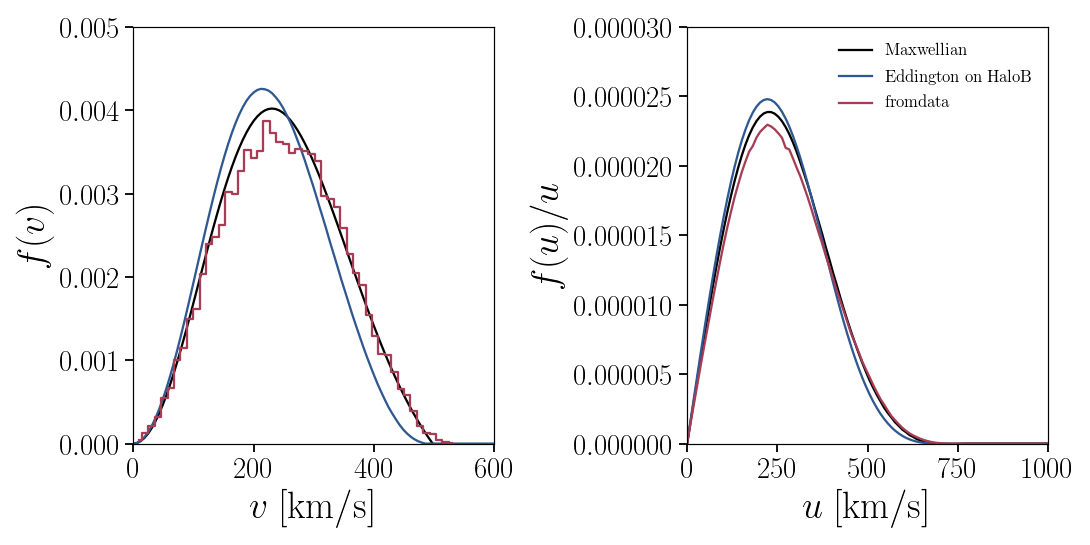

In [552]:
transfor_gal = np.vectorize(vdf.gal_to_sun)

fig, [ax,ax1] =plt.subplots(1,2,figsize=[10,5])
ax.set_ylim([0,0.005])
ax1.set_ylim([0,0.000030])
ax.set_xlim([0,600])
ax1.set_xlim([0,1000])
fonto=25
ax.set_xlabel(r"$v\rm\; [km/s]$",fontsize=fonto)
ax.set_ylabel(r"$f(v)$",fontsize=fonto)
ax1.set_ylabel(r"$f(u)/u$",fontsize=fonto)


ax1.set_xlabel(r"$u\rm\; [km/s]$",fontsize=fonto)


v_array = np.linspace(.1,600,100)
u_array = np.linspace(.1,1000,100)



get_maxHB = np.vectorize(maxwellianHB)
ax.plot(v_array,get_maxHB(v_array),c=shm_color, label=r"$\rm Tsallis$")
ax1.plot(u_array,transfor_gal(u_array,maxwellianHB), c=shm_color, label=r"$\rm Maxwellian$")

eddedd = np.vectorize(edd_HB)
ax.plot(v_array,eddedd(v_array), c=Edd_color)
ax1.plot(u_array,transfor_gal(u_array,edd_HB), c=Edd_color, label=r"$\rm Eddington\;on\;Halo B$")

#get_shm = np.vectorize(vdf.shm_gal)
ax.step(bin_aux, hist_aux,c=data_color,where='mid', label=r"$\rm SHM$")
ax1.plot(u_array,transfor_gal(u_array,discret_f), c=data_color, label=r"$\rm from data$")
ax.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)

leg = ax1.legend(loc='upper right', ncol=1, shadow=False, fontsize=11)
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

# Eddington Mochima



In [564]:
edd_file = np.loadtxt("/home/arturo/Documents/LAM/LAM2LUPM/Mochima/fdvs/fv_Eddington_Mochima2_DM_baryons_Rmax=2908.43kpc_8kpc_no_divergence.txt")
f_edd_HALOB = interp1d(edd_file[:,0],edd_file[:,1])

In [565]:
def edd_HB(x,transform=False,esc=vesc, n=N_tsa ):
    if x>esc:
        return 1e-30
    else:
        try:
            t = f_edd_HALOB(x)
        except:
            t=0
        if not (transform):
            return t
        if (transform):
            return t / x**2 

In [569]:
%%time
fdu_here = edd_HB
n = norms(fdu_here,1e3)
print "sigma"
sigma_edd_HB = get_sigma(mass_array, fdu_here,n)
print "capture"
edd_Mo_cap = E_g(mass_array, fdu_here)

sigma
capture
CPU times: user 5min 20s, sys: 264 ms, total: 5min 21s
Wall time: 5min 21s


# Maxwellian simulation

In [570]:


def maxw(v,sigma,vesc):
    N = np.sqrt(32 * np.pi) * v**2 / sigma**3
    return N * (np.exp(- v**2 / 2. / sigma**2 )- np.exp(-vesc**2/2./sigma**2))


get_maxw = np.vectorize(maxw)
N_max = np.trapz(get_maxw(v_array,184.316,552.56),v_array)

def maxwellianHB(x,transform=False,esc=vesc, n=N_max ):
    sigma8=184.316
    vesc = 552.56
    N = np.sqrt(32 * np.pi) * x**2 / sigma8**3
    if x>esc:
        return 1e-30
    else:
        t = N * (np.exp(- x**2 / 2. / sigma8**2 )- np.exp(-vesc**2/2./sigma8**2))
        if not (transform):
            return t / n
        if (transform):
            return t / x**2 / n

In [571]:
%%time
fdu_here = maxwellianHB
N_max = norms(fdu_here,1e3)
print "sigma"
sigma_edd_HB = get_sigma(mass_array, fdu_here,n)
print "capture"
max_Mo_cap = E_g(mass_array, fdu_here)

sigma
capture
CPU times: user 2min 33s, sys: 1.01 s, total: 2min 34s
Wall time: 2min 33s


# DATA Mochima

In [576]:
%%time
fdu_here = discret_f
#n = norms(fdu_here,1e3)
print "sigma"
#sigma_edd_HB = get_sigma(mass_array, fdu_here,n)
print "capture"
vdf_from_file = np.loadtxt("../../datafiles/rho_vs_t_FILES/Mochima1kpc/fdv_Mo_SF041.txt")
hist_aux = vdf_from_file[:,1]
bin_aux = vdf_from_file[:,0]-(vdf_from_file[1,0]-vdf_from_file[0,0])/2.
wi = bin_aux[1]-bin_aux[0]
bino = np.concatenate([[bin_aux[0]-3*wi,bin_aux[0]-2*wi,bin_aux[0]-wi],bin_aux])
bino = np.concatenate([bino,[bin_aux[-1]+wi,bin_aux[-1]+2*wi,bin_aux[-1]+3*wi]])
histo = np.concatenate([[0,0,0],hist_aux])
histo = np.concatenate([histo,[0,0,0]])
fff = interp1d(bino,histo)
def discret_f(x,transform=False,esc=vesc, n=N_max ):
    if x>esc:
        return 1e-30
    else:
        t = fff(x)
        if not (transform):
            return t
        if (transform):
            return t /x**2 

fdu_here = discret_f

E_g_discrete = np.vectorize(product_d)

data_Mo_cap = E_g(mass_array, fdu_here)

sigma
capture
CPU times: user 3min, sys: 135 ms, total: 3min
Wall time: 3min 1s


<IPython.core.display.Javascript object>


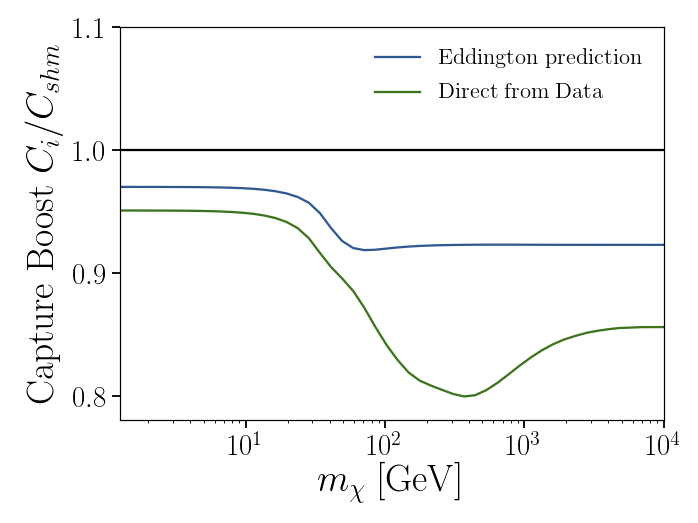

In [592]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_ylim([0.78,1.1])
ax.set_xlim([mass_array[0],mass_array[-1]])

ax.set_xlabel(r"$m_{\chi} \; \rm [GeV]$", fontsize=25)
ax.set_ylabel(r"$\rm Capture\; Boost\;$$ C_i / C_{shm}$", fontsize=25)

#ax.plot(mass_array, tsa_cap / max_HB_cap, c=Tsalis_color, label=r"$\rm Tsallis\; fit$")
#ax.plot(mass_array, gau_cap / max_HB_cap, c=Gau_color, label=r"$\rm Gaussian\;fit$")
ax.plot(mass_array, edd_Mo_cap / max_Mo_cap, c=Edd_color,label=r"$\rm Eddington\;prediction$")
#ax.plot(mass_array, genM_cap / max_HB_cap,c=GenMax_color, label=r"$\rm General\; Maxwellian\; fit$")
ax.plot(mass_array, data_Mo_cap / max_Mo_cap,c=GenMax_color, label=r"$\rm Direct\;from\;Data$")


ax.axhline(y=1, color=shm_color)
ax.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)
leg = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=15)
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

<IPython.core.display.Javascript object>


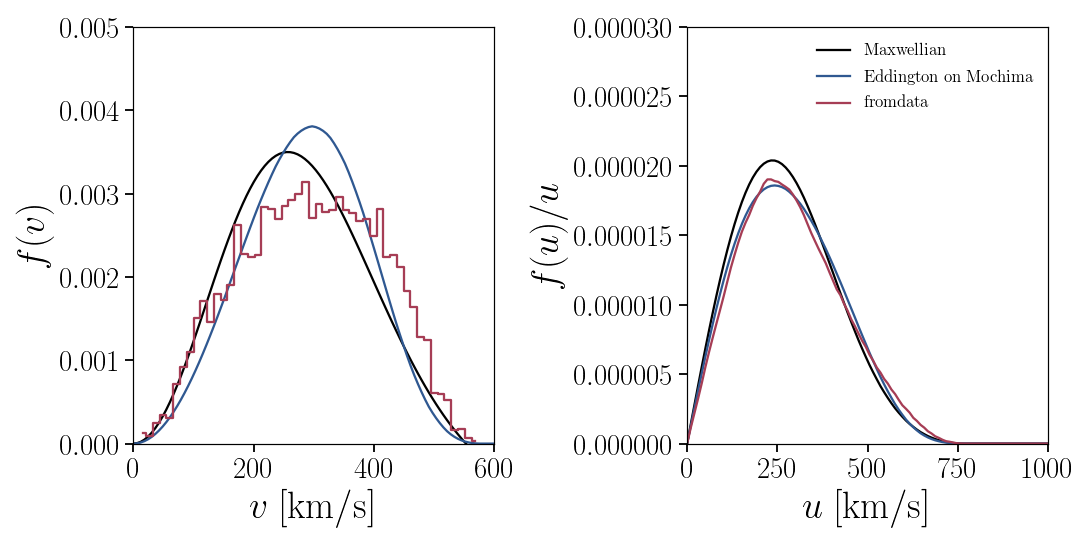

In [584]:
transfor_gal = np.vectorize(vdf.gal_to_sun)

fig, [ax,ax1] =plt.subplots(1,2,figsize=[10,5])
ax.set_ylim([0,0.005])
ax1.set_ylim([0,0.000030])
ax.set_xlim([0,600])
ax1.set_xlim([0,1000])
fonto=25
ax.set_xlabel(r"$v\rm\; [km/s]$",fontsize=fonto)
ax.set_ylabel(r"$f(v)$",fontsize=fonto)
ax1.set_ylabel(r"$f(u)/u$",fontsize=fonto)


ax1.set_xlabel(r"$u\rm\; [km/s]$",fontsize=fonto)


v_array = np.linspace(.1,600,100)
u_array = np.linspace(.1,1000,100)



get_maxHB = np.vectorize(maxwellianHB)
ax.plot(v_array,get_maxHB(v_array),c=shm_color, label=r"$\rm Tsallis$")
ax1.plot(u_array,transfor_gal(u_array,maxwellianHB), c=shm_color, label=r"$\rm Maxwellian$")

eddedd = np.vectorize(edd_HB)
ax.plot(v_array,eddedd(v_array), c=Edd_color)
ax1.plot(u_array,transfor_gal(u_array,edd_HB), c=Edd_color, label=r"$\rm Eddington\;on\;Mochima$")

#get_shm = np.vectorize(vdf.shm_gal)
ax.step(bin_aux, hist_aux,c=data_color,where='mid', label=r"$\rm SHM$")
ax1.plot(u_array,transfor_gal(u_array,discret_f), c=data_color, label=r"$\rm from data$")
ax.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)

leg = ax1.legend(loc='upper right', ncol=1, shadow=False, fontsize=11)
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

<IPython.core.display.Javascript object>


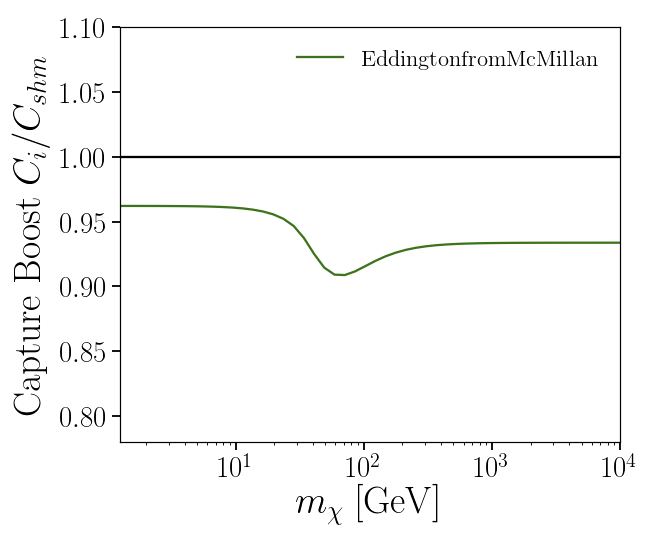

In [594]:
fig, ax = plt.subplots(figsize=[6,5])
ax.set_xscale('log')
ax.set_ylim([0.78,1.1])
ax.set_xlim([mass_array[0],mass_array[-1]])

ax.set_xlabel(r"$m_{\chi} \; \rm [GeV]$", fontsize=25)
ax.set_ylabel(r"$\rm Capture\; Boost\;$$ C_i / C_{shm}$", fontsize=25)

#ax.plot(mass_array, tsa_cap / max_HB_cap, c=Tsalis_color, label=r"$\rm Tsallis\; fit$")
#ax.plot(mass_array, gau_cap / max_HB_cap, c=Gau_color, label=r"$\rm Gaussian\;fit$")
#ax.plot(mass_array, edd_Mo_cap / shm_cap, c=Edd_color,label=r"$\rm Eddinton\;prediction$")
#ax.plot(mass_array, genM_cap / max_HB_cap,c=GenMax_color, label=r"$\rm General\; Maxwellian\; fit$")
ax.plot(mass_array, edd_cap / shm_cap,c=GenMax_color, label=r"$\rm Eddington from McMillan$")


ax.axhline(y=1, color=shm_color)
ax.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)
leg = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=15)
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

<IPython.core.display.Javascript object>


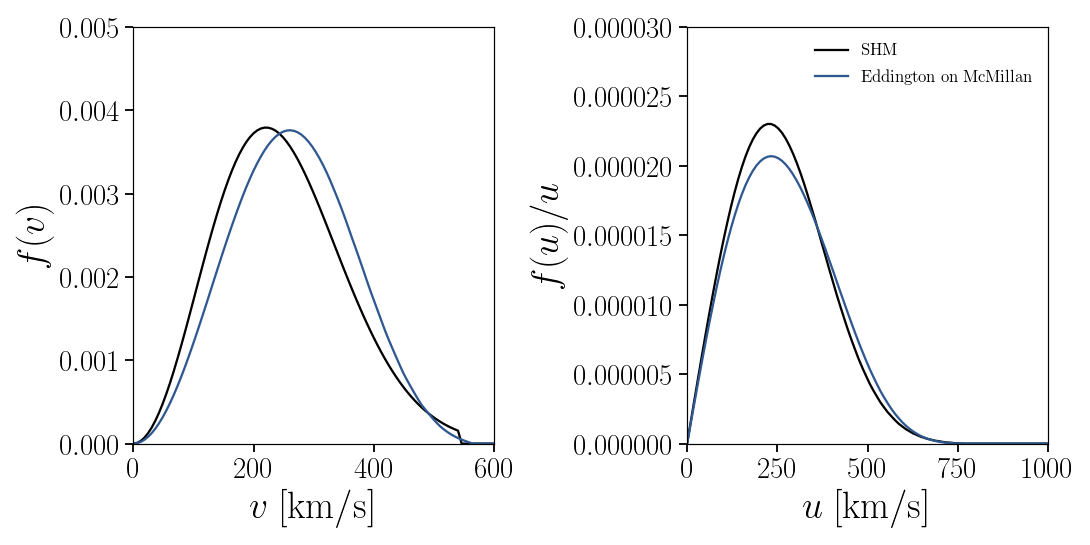

In [600]:
transfor_gal = np.vectorize(vdf.gal_to_sun)

fig, [ax,ax1] =plt.subplots(1,2,figsize=[10,5])
ax.set_ylim([0,0.005])
ax1.set_ylim([0,0.000030])
ax.set_xlim([0,600])
ax1.set_xlim([0,1000])
fonto=25
ax.set_xlabel(r"$v\rm\; [km/s]$",fontsize=fonto)
ax.set_ylabel(r"$f(v)$",fontsize=fonto)
ax1.set_ylabel(r"$f(u)/u$",fontsize=fonto)


ax1.set_xlabel(r"$u\rm\; [km/s]$",fontsize=fonto)


v_array = np.linspace(.1,600,100)
u_array = np.linspace(.1,1000,100)



get_maxHB = np.vectorize(vdf.shm_gal)
ax.plot(v_array,get_maxHB(v_array),c=shm_color, label=r"$\rm Tsallis$")
ax1.plot(u_array,transfor_gal(u_array,vdf.shm_gal), c=shm_color, label=r"$\rm SHM$")

eddedd = np.vectorize(edd_McM)
ax.plot(v_array,eddedd(v_array), c=Edd_color)
ax1.plot(u_array,transfor_gal(u_array,edd_McM), c=Edd_color, label=r"$\rm Eddington\;on\;McMillan$")

#get_shm = np.vectorize(vdf.shm_gal)
#ax.step(bin_aux, hist_aux,c=data_color,where='mid', label=r"$\rm SHM$")
#ax1.plot(u_array,transfor_gal(u_array,discret_f), c=data_color, label=r"$\rm from data$")
ax.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)

leg = ax1.legend(loc='upper right', ncol=1, shadow=False, fontsize=11)
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()